[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\belen\AppData\Roaming\nltk_data...


=== Mean VADER Compound Score by Topic ===
 original_cluster  mean_score
                0    0.222473
                1    0.060751
                2   -0.061598

=== Sentiment Distribution (%) by Topic ===
 original_cluster  negative  neutral  positive
                0      26.2     14.0      59.8
                1       0.0      0.0     100.0
                2      93.3      0.0       6.7


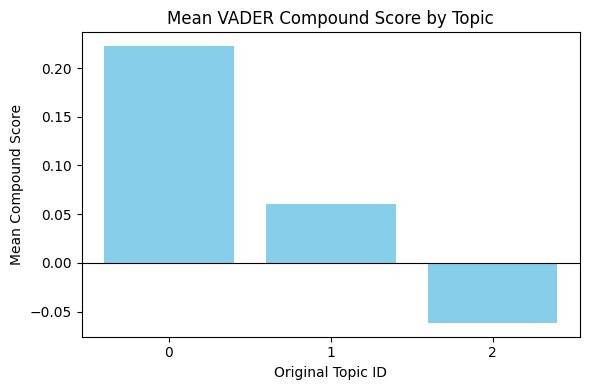

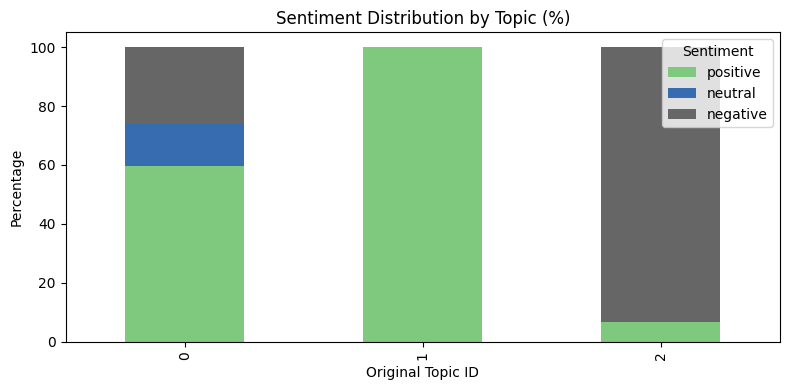

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')

# 0. Carga tu DataFrame preexistente
data = pd.read_csv("data/clustered_with_subclusters.csv")

# 1. Inicializa VADER y calcula score para cada comentario limpiado
sid = SentimentIntensityAnalyzer()
data["sent_score"] = data["comment_clean"] \
    .fillna("") \
    .apply(lambda t: sid.polarity_scores(t)["compound"])

# 2. Asigna etiqueta según umbrales
def label_from_score(x):
    if   x >=  0.05: return "positive"
    if   x <= -0.05: return "negative"
    else:             return "neutral"

data["sent_label"] = data["sent_score"].apply(label_from_score)

# 3. Resume por tópico (original_cluster)
mean_scores = (
    data
    .groupby("original_cluster")["sent_score"]
    .mean()
    .reset_index(name="mean_score")
)

dist_counts = (
    data
    .groupby(["original_cluster","sent_label"])
    .size()
    .unstack(fill_value=0)
)
dist_pct = (
    dist_counts
    .div(dist_counts.sum(axis=1), axis=0)
    .multiply(100)
    .round(1)
    .reset_index()
)

summary = mean_scores.merge(dist_pct, on="original_cluster")

# 4. Mostrar tabla
print("=== Mean VADER Compound Score by Topic ===")
print(summary[["original_cluster","mean_score"]].to_string(index=False))

print("\n=== Sentiment Distribution (%) by Topic ===")
print(summary[["original_cluster","negative","neutral","positive"]]
      .to_string(index=False))

# 5. (Opcional) Gráficos

# a) Mean scores
plt.figure(figsize=(6,4))
plt.bar(
    summary["original_cluster"].astype(str),
    summary["mean_score"],
    color="skyblue"
)
plt.axhline(0, color="black", linewidth=0.8)
plt.title("Mean VADER Compound Score by Topic")
plt.xlabel("Original Topic ID")
plt.ylabel("Mean Compound Score")
plt.tight_layout()
plt.show()

# b) Stacked bar de distribución
plot_df = summary.set_index("original_cluster")[["positive","neutral","negative"]]
plot_df.plot(
    kind="bar",
    stacked=True,
    figsize=(8,4),
    colormap="Accent"
)
plt.title("Sentiment Distribution by Topic (%)")
plt.xlabel("Original Topic ID")
plt.ylabel("Percentage")
plt.legend(title="Sentiment")
plt.tight_layout()
plt.show()
